In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
#from scipy.special import gamma as GammaFunction
import pymc as pm
import arviz as az
import bambi as bmb
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils
import mwm

In [137]:
fpath = '../../results/2023-10-13-5xfad-maze/data_train-CO26990.csv'
data1 = pd.read_csv(fpath, index_col=['cohort', 'group', 'sex', 'irn', 'day'])
data1

Distance  Floating  Latency  Thigmotaxis  \
cohort group sex irn     day                                                
I      A     f   12913 A Day 1  10.841027  0.532622    60.08    66.311600   
                         Day 2   5.720320  7.641773    26.06    33.259165   
                         Day 3   3.967948  9.397345    22.70    16.170368   
                         Day 4   2.178462  6.630220    18.06     7.830300   
                 12915 A Day 1   8.892240  4.043839    47.62    70.582225   
...                                   ...       ...      ...          ...   
III    C     m   13958 A Day 4   3.717858  7.993118    20.74    32.184900   
                 13962 A Day 1  10.552825  1.930759    60.08    44.906775   
                         Day 2   9.089775  0.798936    60.08    18.708375   
                         Day 3   3.030865  7.857635    19.78    15.243320   
                         Day 4   6.122248  4.698587    33.14    25.740050   

                                Velocity Cohort Group Sex      IRN  Day  \
cohort group sex irn     day                                              
I      A     f   12913 A Day 1  0.180684      I     A   f  12913 A  1.0   
                         Day 2  0.202247      I     A   f  12913 A  2.0   
                         Day 3  0.166473      I     A   f  12913 A  3.0   
                         Day 4  0.120461      I     A   f  12913 A  4.0   
                 12915 A Day 1  0.182376      I     A   f  12915 A  1.0   
...                                  ...    ...   ...  ..      ...  ...   
III    C     m   13958 A Day 4  0.165693    III     C   m  13958 A  4.0   
                 13962 A Day 1  0.175880    III     C   m  13962 A  1.0   
                         Day 2  0.151496    III     C   m  13962 A  2.0   
                         Day 3  0.154832    III     C   m  13962 A  3.0   
                         Day 4  0.176833    III     C   m  13962 A  4.0   

                                        Condition Status  
cohort group sex irn     day                              
I      A     f   12913 A Day 1                 WT  right  
                         Day 2                 WT   none  
                         Day 3                 WT   none  
                         Day 4                 WT   none  
                 12915 A Day 1                 WT   none  
...                                           ...    ...  
III    C     m   13958 A Day 4  5xFAD + Amiloride   none  
                 13962 A Day 1  5xFAD + Amiloride  right  
                         Day 2  5xFAD + Amiloride  right  
                         Day 3  5xFAD + Amiloride   none  
                         Day 4  5xFAD + Amiloride   none  

[172 rows x 12 columns]

In [138]:
fpath = '../../results/2023-10-13-5xfad-maze/data_train-CO28152.csv'
data2 = pd.read_csv(fpath, index_col=['cohort', 'group', 'sex', 'irn', 'day'])
data2

Distance (cm)   Floating  Latency  \
cohort group sex irn     day                                        
I      A     f   14627 A Day 1     777.874500   1.331558    60.08   
                         Day 2     678.319250   3.404644    54.28   
                         Day 3     956.991000   1.231691    60.04   
                         Day 4     849.667925   6.595437    48.20   
                 14687 A Day 1     804.980500   1.198402    60.08   
...                                       ...        ...      ...   
VI     J     m   16226   Day 4     681.385500   8.724943    45.64   
                 16234   Day 1     821.930000  18.075912    60.08   
                         Day 2     583.892750  12.500042    45.06   
                         Day 3     637.209750   4.761448    39.08   
                         Day 4     196.447375  10.478817    12.30   

                                Thigmotaxis  Velocity (cm/s) Cohort Group Sex  \
cohort group sex irn     day                                                    
I      A     f   14627 A Day 1    56.790925        12.964550      I     A   f   
                         Day 2    69.234950        12.427325      I     A   f   
                         Day 3    54.427450        15.960700      I     A   f   
                         Day 4    35.809225        15.501930      I     A   f   
                 14687 A Day 1    46.970700        13.416325      I     A   f   
...                                     ...              ...    ...   ...  ..   
VI     J     m   16226   Day 4    38.211750        14.890225     VI     J   m   
                 16234   Day 1    50.599200        13.698863     VI     J   m   
                         Day 2    30.437535        13.445612     VI     J   m   
                         Day 3    31.934103        15.679775     VI     J   m   
                         Day 4    12.971915        15.199125     VI     J   m   

                                    IRN  Day          Condition Status  
cohort group sex irn     day                                            
I      A     f   14627 A Day 1  14627 A  1.0  5xFAD + Amiloride  right  
                         Day 2  14627 A  2.0  5xFAD + Amiloride   none  
                         Day 3  14627 A  3.0  5xFAD + Amiloride  right  
                         Day 4  14627 A  4.0  5xFAD + Amiloride   none  
                 14687 A Day 1  14687 A  1.0  5xFAD + Amiloride  right  
...                                 ...  ...                ...    ...  
VI     J     m   16226   Day 4    16226  4.0          WT + DMSO   none  
                 16234   Day 1    16234  1.0          WT + DMSO  right  
                         Day 2    16234  2.0          WT + DMSO   none  
                         Day 3    16234  3.0          WT + DMSO   none  
                         Day 4    16234  4.0          WT + DMSO   none  

[580 rows x 12 columns]

In [32]:
models1 = {}
models1['base'] = (
    bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + Day + (1 | IRN)',
    data1, 
    family='weibull',
    link='log',
    center_predictors=False),
    [11947, 11949, 11976, 12021]
)
'''
# This isn't useful, after all, because the Day effect is inverted without the Group effect
models1['invertDay'] = (
    bmb.Model(
    'censored(Latency, Status) ~ 1 + Group + I(- Day) + (1 | IRN)',
    data1, 
    family='weibull',
    link='log',
    center_predictors=False),
    [21947, 21949, 21976, 22021]
)
'''

lvl = ['5xFAD', 'WT', '5xFAD + Amiloride']
models1['TgReflevel'] = (
    bmb.Model(
    'censored(Latency, Status) ~ 1 + C(Condition, levels=lvl) + Day + (1 | IRN)',
    data1, 
    family='weibull',
    link='log',
    center_predictors=False),
    [21947, 21949, 21976, 22021]
)


In [33]:
def my_fit(model, mcmc_random_seed):
    try:
        #mcmc_random_seed = [11947, 11949, 11976, 12021]
        val = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=mcmc_random_seed)
    except(pm.SamplingError):
        val = None
    return(val)

idata1 = {k: my_fit(*v) for k, v in models1.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, C(Condition, levels=lvl), Day, 1|IRN_sigma, 1|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [34]:
compare1 = az.compare({k: v for k, v in idata1.items() if v is not None})
compare1

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
base,0,-575.158002,26.751483,0.000000,1.0,18.894471,0.000000,True,log
TgReflevel,1,-575.586544,26.907758,0.428542,0.0,18.863005,0.273084,True,log


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'C(Condition, levels=lvl)'}>,
        <Axes: title={'center': 'C(Condition, levels=lvl)'}>],
       [<Axes: title={'center': 'Day'}>, <Axes: title={'center': 'Day'}>],
       [<Axes: title={'center': 'censored(Latency, Status)_alpha'}>,
        <Axes: title={'center': 'censored(Latency, Status)_alpha'}>],
       [<Axes: title={'center': '1|IRN_sigma'}>,
        <Axes: title={'center': '1|IRN_sigma'}>],
       [<Axes: title={'center': '1|IRN'}>,
        <Axes: title={'center': '1|IRN'}>]], dtype=object)

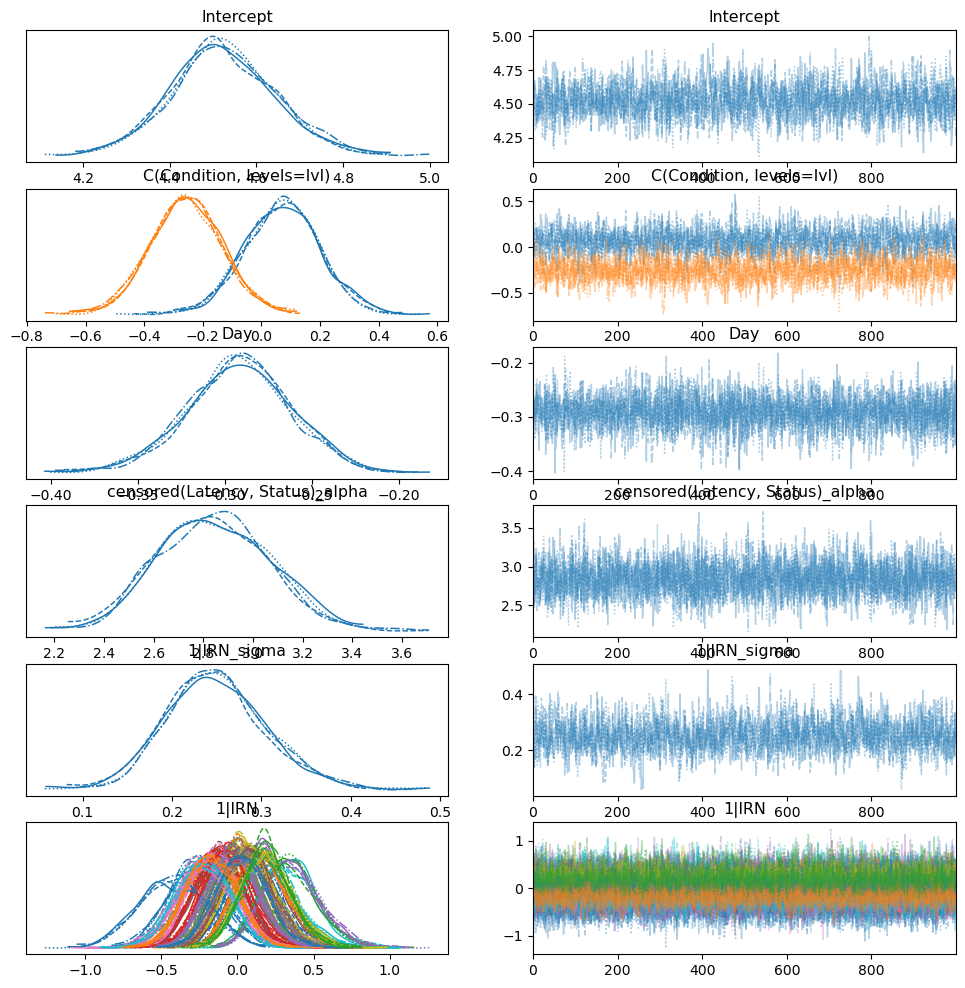

In [35]:
az.plot_trace(idata1['TgReflevel'])

In [143]:
experiments = {
    'Amiloride 10': (data1, ['5xFAD', '5xFAD + Amiloride', 'WT']),
    'Amiloride 12': (data2, ['5xFAD', '5xFAD + Amiloride', 'WT']),
    'HCQ': (data2, ['5xFAD', '5xFAD + HCQ', 'WT']),
    'HCQ': (data2, ['5xFAD', '5xFAD + HCQ nano', 'WT']),
    'R-HCQ': (data2, ['5xFAD', '5xFAD + R-HCQ', 'WT + DMSO']),
    'L-HCQ': (data2, ['5xFAD', '5xFAD + L-HCQ', 'WT + DMSO']),
    'TUDCA': (data2, ['5xFAD', '5xFAD + TUDCA', 'WT']),
    'TUDCA WT': (data2, ['WT', 'WT + TUDCA', '5xFAD']),
}


def fit_one(data, lvl, random_seed=[21947, 21949, 21976, 22021]):
    dat = data.loc[data.Condition.isin(lvl)]
    model = bmb.Model(
        'censored(Latency, Status) ~ 1 + C(Condition, levels=lvl) + Day + (1 | IRN)',
        dat, 
        family='weibull',
        link='log',
        center_predictors=False
    )
    try:
        idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=random_seed)
    except(pm.SamplingError):
        idata = None
    return(idata)


In [133]:
lvl = ['WT + vehicle [saline]', 'WT + vehicle [DMSO,...]', '5xFAD + vehicle [saline]']
idata = fit_one(data2, lvl, random_seed=[21947, 21949, 21976, 22021])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, C(Condition, levels=lvl), Day, 1|IRN_sigma, 1|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'C(Condition, levels=lvl)'}>,
        <Axes: title={'center': 'C(Condition, levels=lvl)'}>],
       [<Axes: title={'center': 'Day'}>, <Axes: title={'center': 'Day'}>],
       [<Axes: title={'center': 'censored(Latency, Status)_alpha'}>,
        <Axes: title={'center': 'censored(Latency, Status)_alpha'}>],
       [<Axes: title={'center': '1|IRN_sigma'}>,
        <Axes: title={'center': '1|IRN_sigma'}>],
       [<Axes: title={'center': '1|IRN'}>,
        <Axes: title={'center': '1|IRN'}>]], dtype=object)

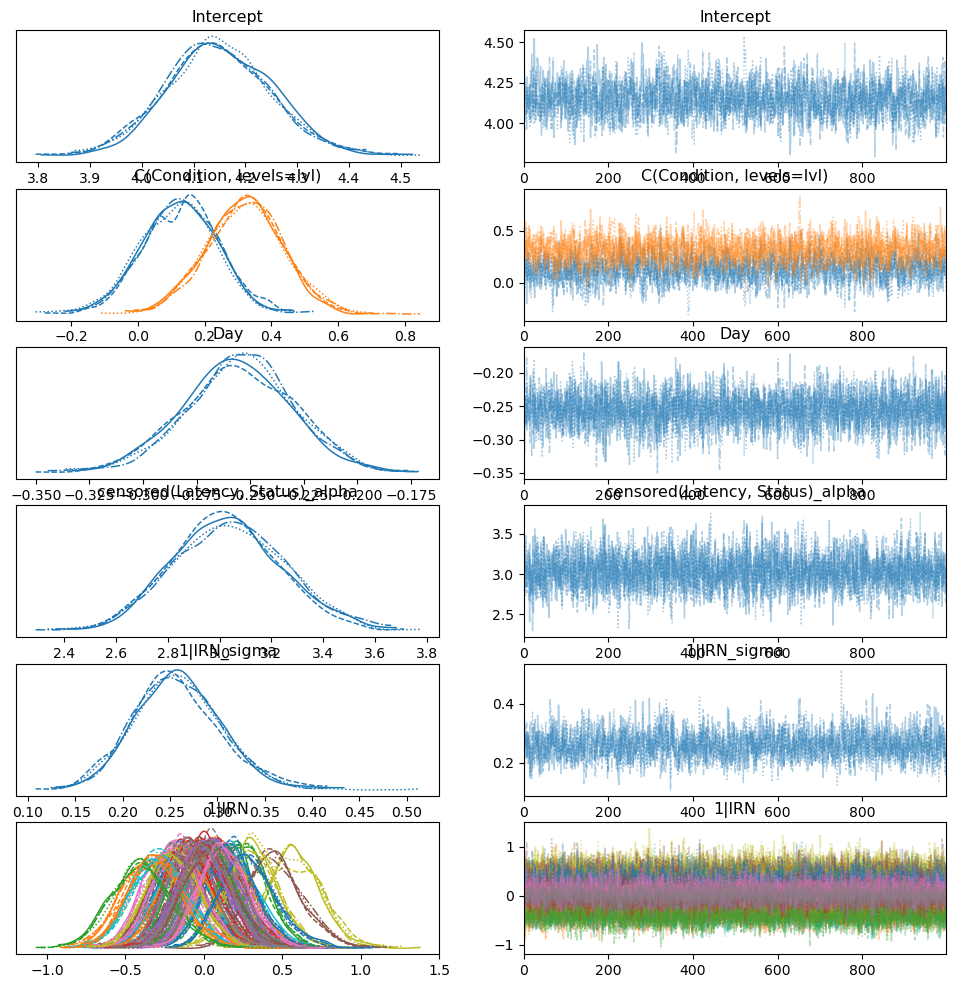

In [134]:
az.plot_trace(idata)

['named-figure/condition-posteriors-study1.png',
 'named-figure/condition-posteriors-study1.pdf']

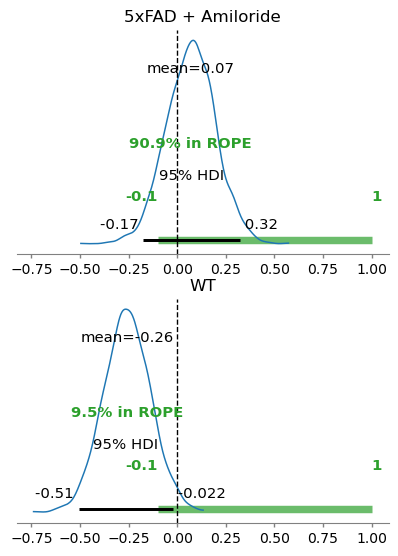

In [114]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(4.8, 6.4))
az.plot_posterior(idata1['TgReflevel'], var_names='C(Condition, levels=lvl)', ax=ax, textsize=10, hdi_prob=0.95, rope=[-0.1, 1])
for i, axi in enumerate(ax):
    axi.set_title(lvl[i + 1])
    axi.axvline(0, linestyle='dashed', color='k', linewidth=1)

attila_utils.savefig(fig, 'condition-posteriors-study1')

<Axes: xlabel='C(Condition, levels=lvl)\n5xFAD + Amiloride', ylabel='C(Condition, levels=lvl)\nWT'>

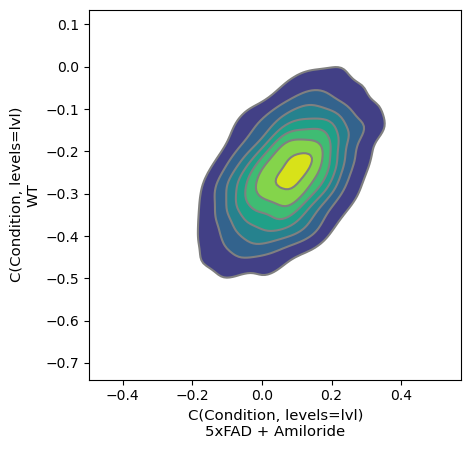

In [61]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4.8, 4.8))
az.plot_pair(idata1['TgReflevel'], var_names='C(Condition, levels=lvl)', ax=ax, kind='kde', textsize=10)

array([[<Axes: title={'center': 'Group\n0, B'}>,
        <Axes: title={'center': 'Group\n0, C'}>,
        <Axes: title={'center': 'Group\n1, B'}>],
       [<Axes: title={'center': 'Group\n1, C'}>,
        <Axes: title={'center': 'Group\n2, B'}>,
        <Axes: title={'center': 'Group\n2, C'}>],
       [<Axes: title={'center': 'Group\n3, B'}>,
        <Axes: title={'center': 'Group\n3, C'}>,
        <Axes: title={'center': 'Day\n0'}>],
       [<Axes: title={'center': 'Day\n1'}>,
        <Axes: title={'center': 'Day\n2'}>,
        <Axes: title={'center': 'Day\n3'}>]], dtype=object)

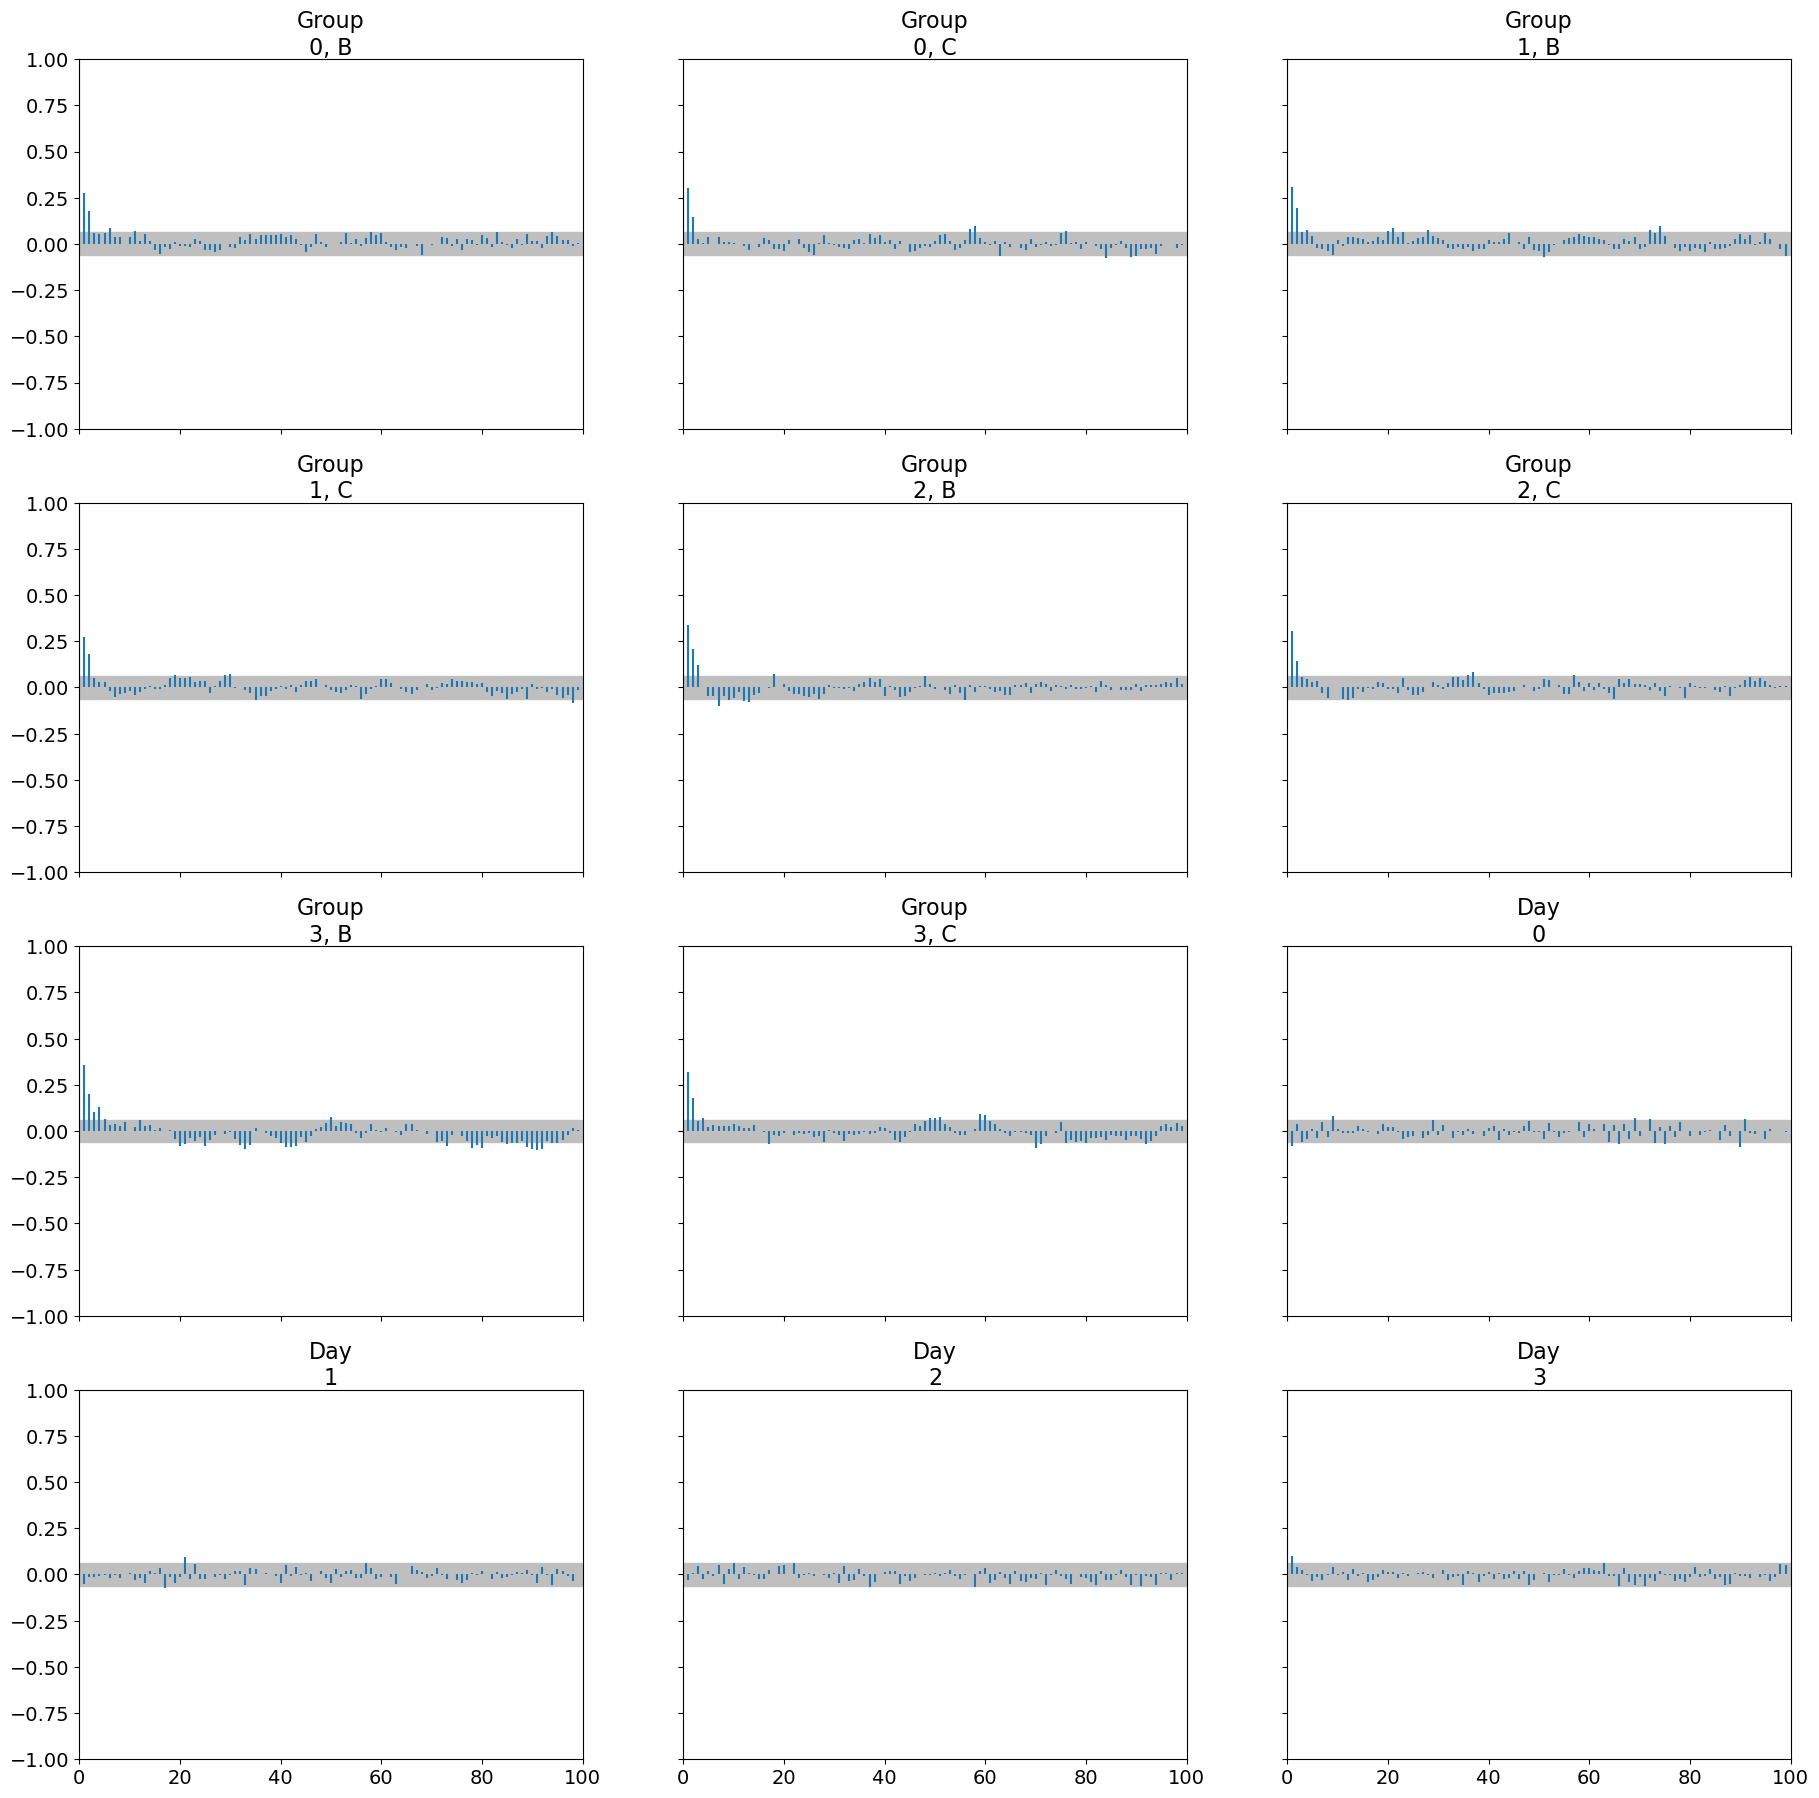

In [111]:
#import arviz.labels
#labeller = arviz.labels.MapLabeller(var_name_map=data1.loc[:, ['Group', 'Condition']].groupby('Group').first().to_dict()['Condition'])
az.plot_autocorr(idata1['base'], var_names=['Group', 'Day'], labeller=labeller)

array([[<Axes: ylabel='Group\nB'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='Group\nC'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='Day'>,
        <Axes: xlabel='Group\nB'>, <Axes: xlabel='Group\nC'>]],
      dtype=object)

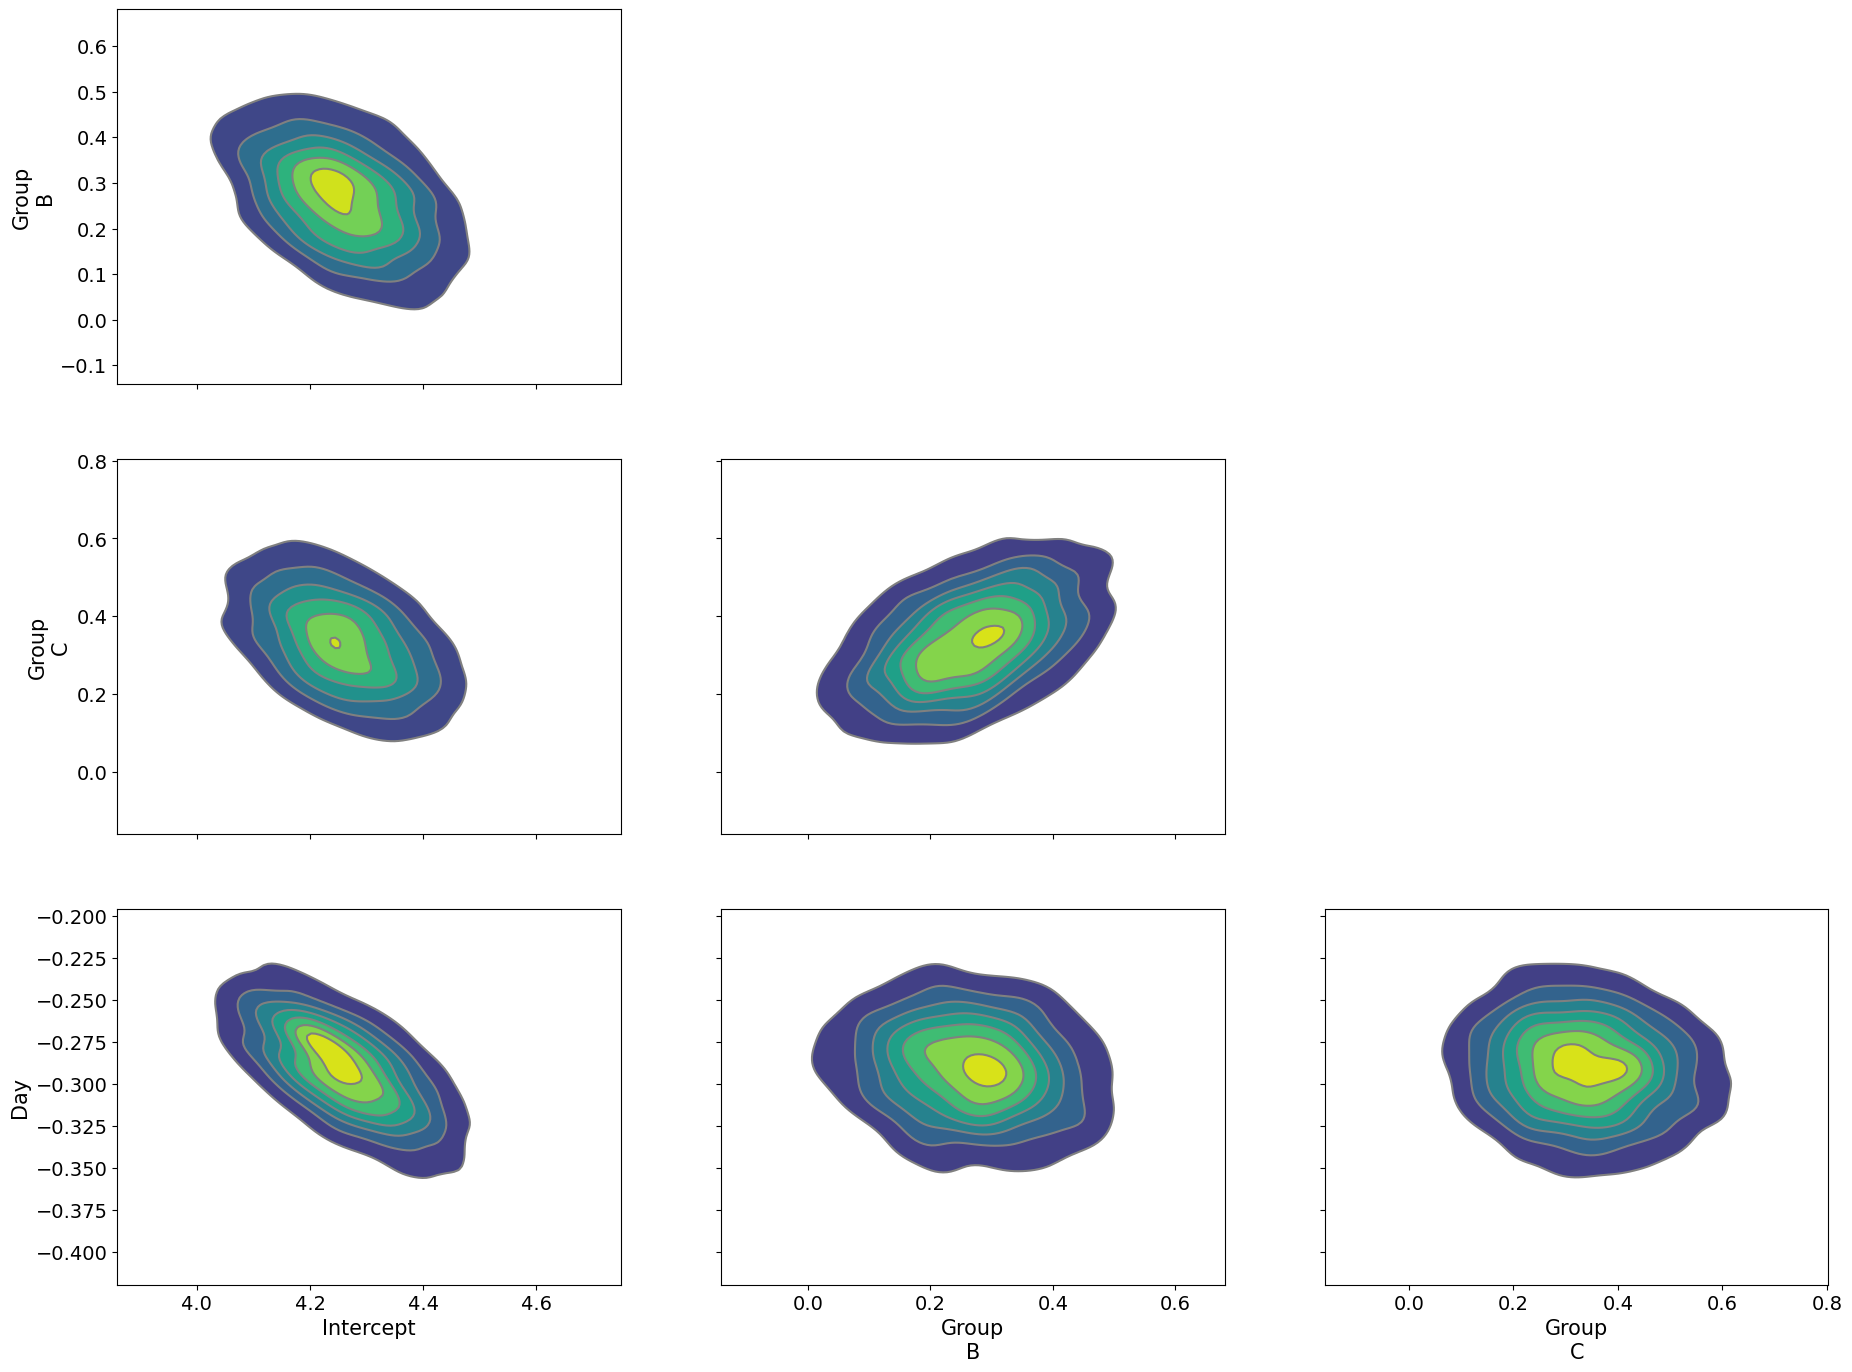

In [113]:
az.plot_pair(idata1['base'], var_names=['Intercept', 'Group', 'Day'], kind='kde')

In [2]:
%connect_info

{
  "shell_port": 55498,
  "iopub_port": 55499,
  "stdin_port": 55500,
  "control_port": 55502,
  "hb_port": 55501,
  "ip": "127.0.0.1",
  "key": "36a5474d-5678cbc3965da755e42aed42",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-620e67fb-0808-4b61-9ec1-14467882a054.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
